### They inner atoms, and the outer atoms are equally spaced

In [2]:
from tqdm import tqdm
from qutip import *
import numpy as np

from scipy.optimize import minimize

import os

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial

In [3]:
save_path = r'C:\Users\Leopold\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [22]:
fixed_lam = 1
fixed_gamma = 1

fixed_dist_ext = 0.235  * fixed_lam
fixed_dist_in  =  fixed_dist_ext
########################################                 Define constants                   #############################################
N = 3 + 3 * 10

In [23]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = 0):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]])

def chain_positions(distance, N):
    Pos = np.zeros((N, 3))
    for i in range(N):
        Pos[i, 0] = i * distance
    return Pos

def topo_positions(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, N = N):
    Pos = np.zeros((N, 3))
#    Chain = chain_positions(distance_ext, N // 3)
#    theta = np.arcsin(1/2)
#    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
#    Pos = Pos[Pos[:, 0].argsort()]
#    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(+theta).T) + [distance_in * np.cos(theta), +distance_in * np.sin(theta), 0]
#    Pos[2*N//3:] = np.dot(Chain, z_rotation(-theta).T)     + [distance_in * np.cos(theta), -distance_in * np.sin(theta), 0]
# HERE IT HAS A DIFFERENT ANGLE! (ORIGIN in middle of triangle) # TODO
    r = distance_in / np.sqrt(3)
    Chain = chain_positions(distance_ext, N // 3) + [r, 0, 0]
    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(2 * np.pi / 6).T)
    Pos[2*N//3:] = np.dot(Chain, z_rotation(-2 * np.pi / 6).T)
    return Pos
# Function to create positions for a topology with three chains meeting at the origin
def topo_positions_only_1_inner(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, N = N):
    if distance_in >= 2 * distance_ext:
        raise ValueError("The distance distance_in is too large to form a valid triangle with distance_ext.")
    Pos = np.zeros((N, 3))
    Chain = chain_positions(distance_ext, N // 3)
    theta = np.arcsin(distance_in / (2 * distance_ext))
    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(+theta).T) + [distance_ext * np.cos(theta), +distance_ext * np.sin(theta), 0]
    Pos[2*N//3:] = np.dot(Chain, z_rotation(-theta).T)     + [distance_ext * np.cos(theta), -distance_ext * np.sin(theta), 0]
    return Pos
positions = topo_positions(0.8 * fixed_dist_in, fixed_dist_in)

In [24]:
########################################             create the Hamiltonean                 #################################################
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma):
    positions = topo_positions(distance_in, distance_ext)
    G_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            G_matrix[a, b] = gamma
            r_a, r_b = positions[a], positions[b]
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                G_matrix[a, b] = np.imag((6 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return G_matrix

def V_matrix(distance_in, distance_ext, dipoles, lam, gamma):
    positions = topo_positions(distance_in, distance_ext)
    V_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                V_matrix[a, b] = np.real((3 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return V_matrix
    
def H_eff(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, dipoles = [dipole_vector() for _ in range(N)], lam=fixed_lam, gamma=fixed_gamma):
    G = Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma)
    V = V_matrix(distance_in, distance_ext, dipoles, lam, gamma)
    return Qobj(V) - 1j / 2 * Qobj(G)

In [25]:
# ###############
# For Optimization and plotting
# ###############
from scipy.optimize import minimize
def survival_probabilities(dipoles, distance_in, times, distance_ext=fixed_dist_ext, lam=fixed_lam, gamma=fixed_gamma, Psi_0=psi0):
    H = H_eff(distance_in, distance_ext, dipoles, lam, gamma)
    coeffs_sq_mods  = np.zeros((len(times), N))
    P_surs  = np.zeros((len(times)))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2
        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()
    return coeffs_sq_mods, P_surs

def dipole_angles_and_distance(params):
    angles = params[:N]
    distance_in = params[N]
    dipoles = [dipole_vector(angle) for angle in angles]
    return dipoles, distance_in

def optimization_target(params, times, target_indices):
    dipoles, distance_in = dipole_angles_and_distance(params)
    res, _ = survival_probabilities(dipoles, distance_in, times)
    # Sum probabilities of the states in the target indices
    target_prob = np.sum(res[-1, target_indices])
    # We want to maximize the target probability
    return -target_prob


In [26]:
################ initiate Wave-packet
def create_wave_packet(N):
    center_index = N // 6
    x_j = (np.arange(N//3) - center_index) * fixed_dist_ext
    coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
    wave_packet = sum(coeff * basis(N, j) for j, coeff in enumerate(coefficients))
    return wave_packet.unit()

In [51]:
# Initial guess for the distance
initial_distance = 0.234 * fixed_lam
initial_angles = np.zeros(N)
initial_params = np.hstack((initial_angles, initial_distance))

# Bounds for the optimization
angle_bounds = [(0, 2*np.pi) for _ in range(N)]
distance_in_bounds = [(0.1, 1)]
bounds = angle_bounds + distance_in_bounds

# Indices of the atoms in the target regions
target_indices = list(range(N//3, 2*N//3-1))  # Example, assuming the target regions are the second third

# Optimization with bounds
result = minimize(optimization_target, initial_params, args=(times, target_indices), bounds=bounds, method='SLSQP')

# Debugging print statements
print("Optimization result:", result)

# Print results
print("Optimized Angles:", result.x[:N])
print("Optimized Inner Distance:", result.x[N])
''''''

Optimization result:  message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.5484168879410345
       x: [ 9.951e-01  7.400e-01 ...  0.000e+00  2.545e-01]
     nit: 97
     jac: [ 2.181e-04 -3.118e-04 ...  4.213e-04  1.185e-03]
    nfev: 1988
    njev: 97
Optimized Angles: [9.95074875e-01 7.39963634e-01 5.48045240e-01 4.44751429e-01
 3.93275926e-01 4.20953045e-01 6.26018444e-01 6.48782542e-01
 5.80736362e-01 4.42436251e-01 1.76411290e-01 0.00000000e+00
 5.80216864e-01 2.43449954e+00 3.92189228e-17 1.15335906e-17
 1.48736207e+00 0.00000000e+00]
Optimized Inner Distance: 0.2544698986134335


''

In [62]:
dipoles, optimized_distance_in = dipole_angles_and_distance(result.x)
dipoles[-2] = np.array([1,0,0])
dipoles[-5] = np.array([1,0,0])
#dipoles[-8] = np.array([1,0,0])

y1, y2 = survival_probabilities(dipoles, optimized_distance_in, times, Psi_0=psi0)

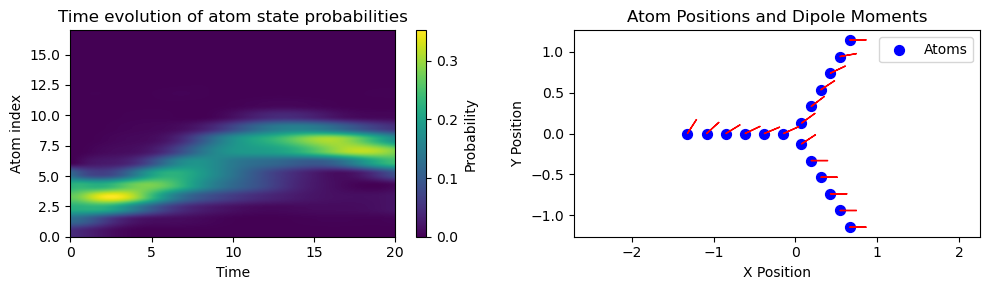

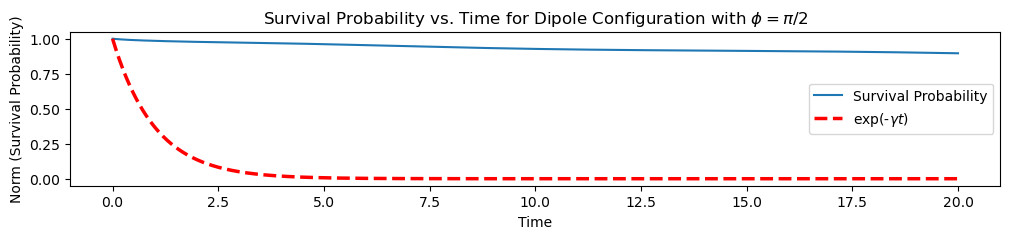

In [63]:
# Plot atoms with their dipole moments
positions = topo_positions(optimized_distance_in)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot the evolution of atom state probabilities
im = ax1.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
ax1.set_xlabel('Time')
ax1.set_ylabel('Atom index')
ax1.set_title('Time evolution of atom state probabilities')
fig.colorbar(im, ax=ax1, label='Probability')

# Plot atoms with their dipole moments
ax2.scatter(positions[:, 0], positions[:, 1], color='blue', s=50, label='Atoms')
for i in range(N):
    ax2.arrow(positions[i, 0], positions[i, 1], dipoles[i][0] * 0.2, dipoles[i][1] * 0.2, head_width=0.5 * 0.01, head_length=0.5 * 0.01, fc='red', ec='red')
ax2.set_title('Atom Positions and Dipole Moments')
ax2.set_xlabel('x / $\lambda$')
ax2.set_ylabel('y / $\lambda$')
ax2.legend()
ax2.axis('equal')

plt.tight_layout()
plt.show()

# Plot the norms against time
plt.figure(figsize=(12, 2))
plt.plot(times, y2, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time') 
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time for Dipole Configuration with $\phi = \pi/2$')
plt.legend()
plt.show()

In [ ]:
 # Find optimal phi for the specific dipole vector
def optimize_single_dipole_phi(atom_index, times, initial_angle, target_indices):
    def single_dipole_target(phi):
        dipoles = dip
        dipoles[atom_index] = dipole_vector(phi[0])
        res, _ = survival_probabilities(dipoles, dist, times)
        target_prob = np.sum(res[-1, target_indices])
        return -target_prob
    
    result = minimize(single_dipole_target, initial_angle, bounds=[(0, 2*np.pi)], method='SLSQP')
    return result

# Specific atom of interest
atom_index = -N//3

# Optimize phi for the specific atom
phi_result = optimize_single_dipole_phi(atom_index, times, initial_phi, target_indices)

# Print the optimized phi value
optimized_phi = phi_result.x[0]
print("Optimized phi for atom index {}: {}".format(atom_index, optimized_phi))

# Update the dipoles with the optimized phi
dipoles, _ = dipole_angles_and_distance(np.hstack((optimized_angles, optimized_distance_in)))
dipoles[atom_index] = dipole_vector(optimized_phi)

In [ ]:
# Recalculate survival probabilities with the optimized phi
y1, y2 = survival_probabilities(dipoles, optimized_distance_in, times, Psi_0=psi01)

# Plot atoms with their dipole moments
positions = topo_positions(optimized_distance_in)
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i, position in enumerate(positions):
    plt.arrow(position[0], position[1], dipoles[i][0] * 0.15, dipoles[i][1] * 0.15, head_width=0.1, head_length=0.1, fc='r', ec='r')
plt.title('Atom Positions and Dipole Moments')
plt.xlabel('x / $\lambda$')
plt.ylabel('y / $\lambda$')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

# Create a heatmap for state probabilities
plt.figure(figsize=(8, 6))
plt.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, times[-1], 0, N])
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('Atom index - centered_index')
plt.title('Time evolution of atom state probabilities')
plt.show()

# Plot survival probability
plt.figure(figsize=(10, 2))
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.plot(times, y2, 'b-', label='Survival Probability')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Probability over time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

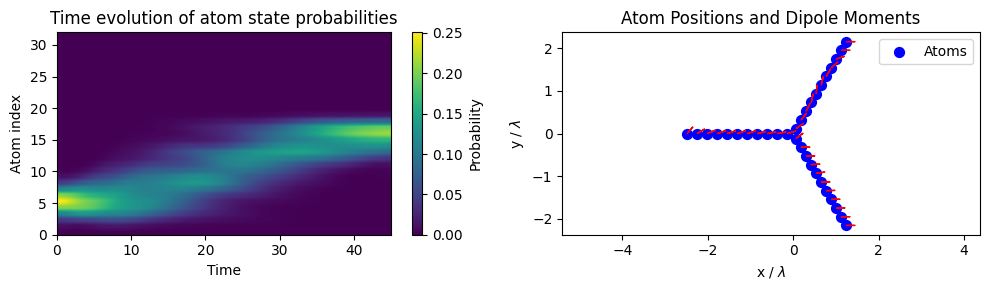

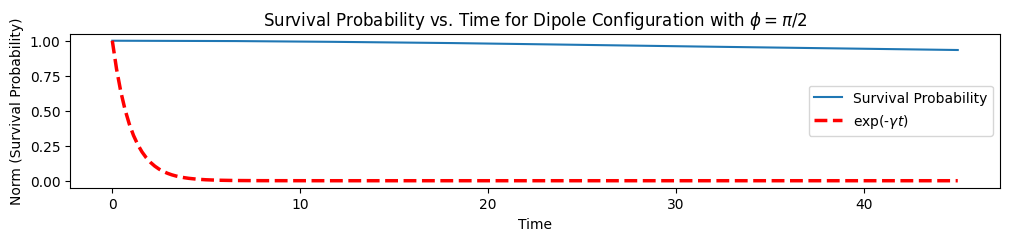

In [27]:
# Set up initial conditions
t_max    = 45
t_size    = 200

########################################################################################################################    
times  = np.linspace(0, t_max, t_size) * fixed_gamma

N=33
optimized_distance_in = 0.234 * fixed_lam
optimized_angles = [8.56243885e-01, 5.45393047e-01, 3.85418697e-01, 3.18513591e-01, 3.09201236e-01, 3.18809638e-01, 3.02352737e-01, 2.45478456e-01, 1.90687899e-01, 1.81840059e-01, 2.92083938e-01, 6.11810003e-01, 9.01226926e-01, 1.11087273e+00, 1.33708053e+00, 1.48645068e+00, 1.33431484e+00, 1.03719638e+00, 7.11143820e-01, 3.11570521e-01, 0.00000000e+00, 2.75855356e-19, 6.56744532e-01, 0.00000000e+00, 2.70445385e-19, 4.83460526e-02, 1.36868323e-01, 2.92998383e-04, 2.99060327e-02, 4.23999898e-03, 1.86039360e-02, 4.04483397e-03, 8.60705448e-04]
# Initial dipoles and positions
dipoles = [dipole_vector(ang) for ang in optimized_angles]
positions = topo_positions(optimized_distance_in)
y1, y2 = survival_probabilities(dipoles, optimized_distance_in, times, Psi_0=create_wave_packet(N))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
# Plot the evolution of atom state probabilities
im = ax1.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
ax1.set_xlabel('Time')
ax1.set_ylabel('Atom index')
ax1.set_title('Time evolution of atom state probabilities')
fig.colorbar(im, ax=ax1, label='Probability')

# Plot atoms with their dipole moments
ax2.scatter(positions[:, 0], positions[:, 1], color='blue', s=50, label='Atoms')
for i in range(N):
    ax2.arrow(positions[i, 0], positions[i, 1], dipoles[i][0] * 0.2, dipoles[i][1] * 0.2, head_width=0.5 * 0.01, head_length=0.5 * 0.01, fc='red', ec='red')
ax2.set_title('Atom Positions and Dipole Moments')
ax2.set_xlabel('x / $\lambda$')
ax2.set_ylabel('y / $\lambda$')
ax2.legend()
ax2.axis('equal')

plt.tight_layout()
plt.show()

# Plot the norms against time
plt.figure(figsize=(12, 2))
plt.plot(times, y2, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time') 
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time for Dipole Configuration with $\phi = \pi/2$')
plt.legend()
plt.show()

In [164]:
# Plot the evolution of atom state probabilities
fig, ax1 = plt.subplots(figsize=(10, 3))
im = ax1.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
ax1.set_xlabel('Time')
ax1.set_ylabel('Atom index')
ax1.set_title('Time evolution of atom state probabilities')
fig.colorbar(im, ax=ax1, label='Probability')
plt.tight_layout()
plt.savefig('time_evolution_probabilities.svg')
plt.close(fig)

# Plot the norms against time
fig, ax2 = plt.subplots(figsize=(10, 3))
ax2.plot(times, y2, label='Survival Probability')
ax2.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Norm (Survival Probability)')
ax2.set_title('Survival Probability vs. Time for Dipole Configuration with $\phi = \pi/2$')
ax2.legend()
plt.tight_layout()
plt.savefig(save_path + 'survival_probability.svg')
plt.close(fig)

# Combined plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot the evolution of atom state probabilities
im = ax1.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
ax1.set_ylabel('Atom index')
ax1.set_title('Time evolution of atom state probabilities')
fig.colorbar(im, ax=ax1, label='Probability')

# Plot the norms against time
ax2.plot(times, y2, label='Survival Probability')
ax2.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Norm (Survival Probability)')
ax2.set_title('Survival Probability vs. Time for Dipole Configuration with $\phi = \pi/2$')
ax2.legend()

plt.tight_layout()
plt.savefig('combined_plot.svg')
plt.close(fig)

Distances: 100%|██████████| 200/200 [00:46<00:00,  4.32it/s]


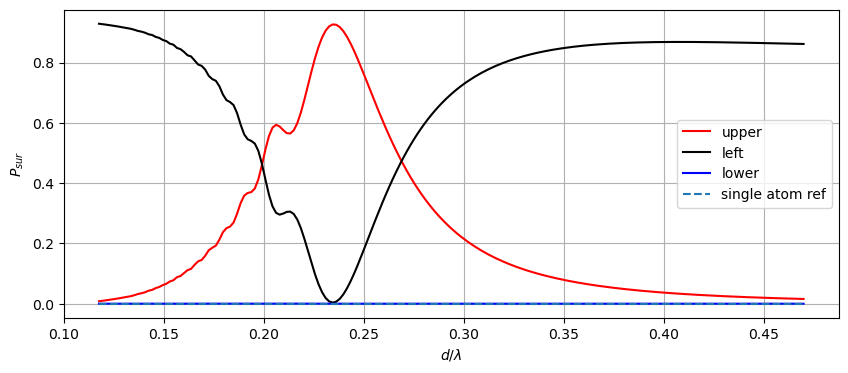

In [158]:
P_sur_upper = np.zeros(dist_size)
P_sur_lower = np.zeros(dist_size)
P_sur_back  = np.zeros(dist_size)

for i, dist in enumerate(tqdm(dists, desc='Distances')):
    y1, y2 = survival_probabilities(dipoles, dist, [times[-1]], Psi_0=psi0)
    P_sur_upper[i] = y1[end_time_index, list(range(N//3, 2*N//3-1))].sum()
    P_sur_lower[i] = y1[end_time_index, list(range(2*N//3, N))].sum()
    P_sur_back[i]  = y1[end_time_index, list(range(0, N//3-1))].sum()

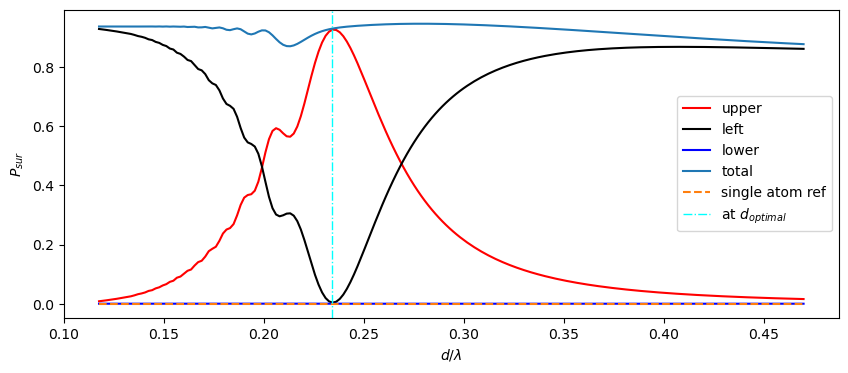

In [216]:
plt.figure(figsize=(10, 4))
plt.plot(dists, P_sur_upper, label='upper', color='red')
plt.plot(dists, P_sur_back, label='left', color='black')
plt.plot(dists, P_sur_lower, label='lower', color='blue')
plt.plot(dists, P_sur_lower + P_sur_upper + P_sur_back, label='total')
plt.plot(dists, np.exp(-times[-1] * fixed_gamma) * np.ones_like(dists), label='single atom ref', linestyle='--')
plt.axvline(x=optimized_distance_in, color='cyan', linestyle='-.', linewidth=1, label='at $d_{optimal}$')
plt.xlabel('$d / \lambda$')
plt.ylabel('$P_{sur}$')
#plt.title('Survival Probability vs. Distance')
plt.legend()
#plt.savefig("P_sur(r).svg", format='svg')
plt.show()

In [173]:
def total_phase(distance, dipoles):
    dist_in = distance
    dist_ext = fixed_dist_ext
    H = H_eff(distance_in = dist_in, distance_ext = dist_ext, dipoles=dipoles, lam=fixed_lam, gamma=fixed_gamma)
    return (np.angle(H[N//3 - 1 , N//3]) +
            np.angle(H[N//3, 2*N//3]) +
            np.angle(H[2*N//3, N//3 - 1]))

def total_phases(distances, dipoles):
    total_ps = np.zeros((len(distances)))
    for i, distance in enumerate(tqdm(distances, desc='Iteration')):
        total_ps[i] = total_phase(distance, dipoles)
    return total_ps
dist_0   = fixed_dist_in / 2
dist_max = 2 * fixed_dist_in
dist_size = 200
dists  = np.linspace(dist_0, dist_max, dist_size)

phases = total_phases(dists, dipoles)

Iteration: 100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


[-1.9596589  -1.97245629 -1.98620315 -2.00081992 -2.01623577 -2.03238753
 -2.04921868 -2.06667858 -2.08472171 -2.10330709 -2.1223977  -2.14196005
 -2.16196379 -2.18238131 -2.20318748 -2.22435935 -2.24587595 -2.26771804
 -2.28986798 -2.31230953 -2.33502772 -2.35800874 -2.38123981 -2.40470909
 -2.42840559 -2.45231911 -2.47644014 -2.50075982 -2.52526987 -2.54996256
 -2.57483064 -2.5998673  -2.62506618 -2.65042127 -2.67592691 -2.7015778
 -2.72736889 -2.75329544 -2.77935296 -2.8055372  -2.83184412 -2.85826988
 -2.88481086 -2.9114636  -2.9382248  -2.96509132 -2.99206018 -3.01912851
 -3.04629359 -3.0735528  -3.10090365 -3.12834374 -3.15587079 -3.18348259
 -3.21117702 -3.23895207 -3.26680578 -3.29473627 -3.32274174 -3.35082045
 -3.37897072 -3.40719094 -3.43547953 -3.46383501 -3.4922559  -3.52074081
 -3.54928838 -3.57789728 -3.60656625 -3.63529405 -3.66407948 -3.69292139
 -3.72181865 -3.75077018 -3.77977491 -3.80883182 -3.8379399  -3.8670982
 -3.89630577 -3.92556168 -3.95486506 -3.98421503 -4.0

Iteration: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


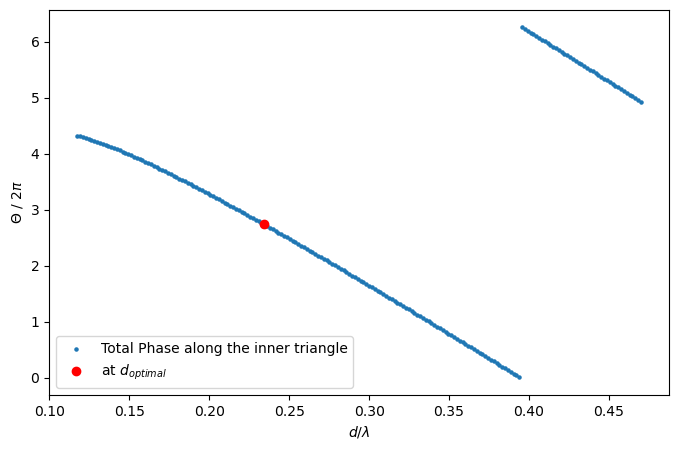

In [194]:
# Plot der Phasen über die Distanzen
print(phases)
plt.figure(figsize=(8, 5))
plt.scatter(dists, phases % (2 * np.pi), s=5, label=r'Total Phase along the inner triangle')  # Smaller circles
plt.plot(optimized_distance_in, total_phases([optimized_distance_in], dipoles)[0] %5 (2*np.pi), 'ro', label='at $d_{optimal}$')

#plt.axvline(x=dist_0, color='r', linestyle='--', label=r'$0.5 \times \text{fixed\_dist\_in}$')
#plt.axvline(x=dist_max, color='b', linestyle='--', label=r'$2 \times \text{fixed\_dist\_in}$')
plt.xlabel(r'$d / \lambda$')
plt.ylabel(r'$\Theta$ / $2\pi$')
#plt.title(f'Phase of off-diagonal entries of H over distance for $\\phi$')
plt.legend(loc='lower left')
plt.savefig("phases_plot.svg", format='svg')
plt.show()

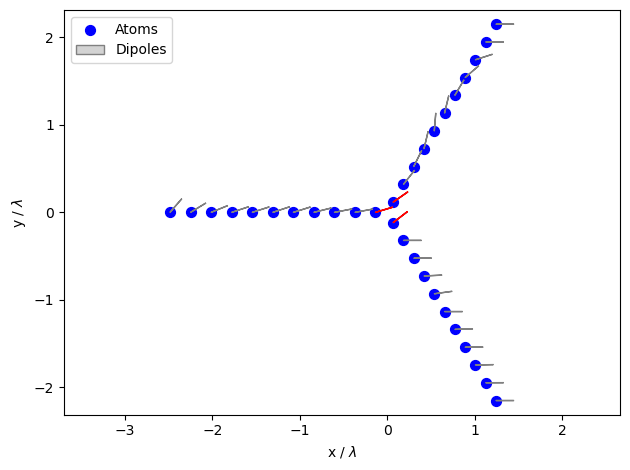

In [129]:
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=50, label='Atoms')
for i in range(N):
    if i == 0:  # Nur beim ersten Dipol ein Label hinzufügen
        plt.arrow(positions[i, 0], positions[i, 1], dipoles[i][0] * 0.2, dipoles[i][1] * 0.2, head_width=0.5 * 0.01, head_length=0.5 * 0.01, fc='lightgrey', ec='grey', label='Dipoles')
    else:
        plt.arrow(positions[i, 0], positions[i, 1], dipoles[i][0] * 0.2, dipoles[i][1] * 0.2, head_width=0.5 * 0.01, head_length=0.5 * 0.01, fc='lightgrey', ec='grey')
highlight_indices = [N//3, N//3 - 1, 2 * N//3]
for idx in highlight_indices:
    plt.arrow(positions[idx, 0], positions[idx, 1], dipoles[idx][0] * 0.2, dipoles[idx][1] * 0.2, head_width=0.5 * 0.01, head_length=0.5 * 0.01, fc='red', ec='red')

plt.xlabel('x / $\lambda$')
plt.ylabel('y / $\lambda$')
plt.legend()
plt.axis('equal')
plt.tight_layout()
#plt.savefig("Dipoles.svg", format='svg')
plt.show()